## Решение курсового проекта 2-ой части Библиотек python для DS

In [538]:
import numpy as np 
import pandas as pd 


from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

In [539]:
import warnings
warnings.simplefilter('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = (6, 4)

Пути к файлам и загрузка данных

In [540]:
TRAIN_DATASET_PATH = '../input/gb-credit-default/train.csv'
TEST_DATASET_PATH = '../input/gb-credit-default/test.csv'
SUBMIT_DATASET_PATH = '../input/gb-credit-default/sample_submission.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
submit = pd.read_csv(SUBMIT_DATASET_PATH)
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

In [541]:
def get_classification_report(classifier, y_train_pred, y_test_pred, y_train, y_test):
    
    print('TRAIN\n\n' + classification_report(y_train, y_train_pred))
    print('TEST\n\n' + classification_report(y_test, y_test_pred))

    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test, y_test_pred))

In [542]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold)), zero_division=1))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [543]:
def get_learning_curve_plot(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring='f1',
                                                            train_sizes=train_sizes, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [544]:
def get_df_info(df):
    data=df.copy()
    mask=data.isnull()
    missing=mask.sum()
    missing_percent=mask.mean()*100
    data_types=data.dtypes
    unique_values=data.nunique()
    data=pd.concat([data.count(), missing, missing_percent, data_types, unique_values],
                   axis=1,
                   keys=['Total count','Total missing', 'Percent missing', 'Types', 'Unique values']).sort_values(
        by='Total missing', ascending=False)
    return data

In [545]:
def get_feature_imp(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    if get_top is not None:
        feature_importances=feature_importances.sort_values('importance', ascending=False)[:get_top]
    else:          
        feature_importances = feature_importances.sort_values('importance', ascending=False)
    
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(x='importance', y='feature', data=feature_importances)
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

Check data

In [546]:
get_df_info(df_train)

,Total count,Total missing,Percent missing,Types,Unique values
Months since last delinquent,3419,4081,54.41,float64,89
Credit Score,5943,1557,20.76,float64,268
Annual Income,5943,1557,20.76,float64,5478
Years in current job,7129,371,4.95,object,11
Bankruptcies,7486,14,0.19,float64,5
Purpose,7500,0,0.00,object,15
Monthly Debt,7500,0,0.00,float64,6716
Current Credit Balance,7500,0,0.00,float64,6592
Current Loan Amount,7500,0,0.00,float64,5386
Term,7500,0,0.00,object,2


In [547]:
get_df_info(df_test)

,Total count,Total missing,Percent missing,Types,Unique values
Months since last delinquent,1142,1358,54.32,float64,83
Annual Income,1987,513,20.52,float64,1929
Credit Score,1987,513,20.52,float64,211
Years in current job,2414,86,3.44,object,11
Bankruptcies,2497,3,0.12,float64,6
Home Ownership,2500,0,0.00,object,4
Tax Liens,2500,0,0.00,float64,8
Number of Open Accounts,2500,0,0.00,float64,35
Years of Credit History,2500,0,0.00,float64,345
Maximum Open Credit,2500,0,0.00,float64,2435


In [548]:
TARGET_VAR='Credit Default'
df_train[TARGET_VAR].value_counts(normalize=True)

0   0.72
1   0.28
Name: Credit Default, dtype: float64

The samples are similar in the amount of missing data. The sample is unbalanced, the target class is found 2.5 times less often.

Check for categorical signs

In [549]:
cat_feature=df_train.select_dtypes(include='object').columns
for name in cat_feature:
    diff=list(set(df_test[name].unique())^set(df_train[name].unique()))
    print(f'Признак: {name: >20}\tРазница присутствует?: {", ".join(diff[i] for i in range(len(diff))) if len(diff)!=0 else "NO": >17}')

Признак:       Home Ownership	Разница присутствует?:                NO
Признак: Years in current job	Разница присутствует?:                NO
Признак:              Purpose	Разница присутствует?:  renewable energy
Признак:                 Term	Разница присутствует?:                NO


RandomForestClassifier is selected because it is easy and faster to use and gives the desired result

feature handling and splitting it to train and validation samples, model fitting

In [550]:
class FeatureHandler:
    count=0
    def __init__(self):
        self.count+=1
        
    
    def fit(self, X, y=None):
        self.dummy_col=['Home Ownership', 'Term', 'Years in current job_ord', 'Purpose_ord']
        self.purpose_change='vacation'
        self.ownership_change='Home Mortgage'
        self.dct={'unknow':0,
                  '< 1 year':1,
                  '1 year':2,
                  '2 years':3,
                  '3 years':4,
                  '4 years':5,
                  '5 years':6,
                  '6 years':7,
                  '7 years':8,
                  '8 years':9,
                  '9 years':10,
                  '10+ years':11}
        self.dct1={'business loan':0,
                   'buy a car':1,
                   'buy house':2,
                   'debt consolidation':3,
                   'educational expenses':4,
                   'home improvements':5,
                   'major purchase':6,
                   'medical bills':7,
                   'moving':8,
                   'other':9,
                   'small business':10,
                   'take a trip':11,
                   'vacation':12,
                   'wedding':13}
        self.drop_col=['Years in current job', 'Purpose']
        
        self.mean=int(X['Months since last delinquent'].mean())
        
        return self
    def transform(self, X):
        X_trans=X.copy()
        X_trans.loc[X_trans['Purpose']=='renewable energy', 'Purpose']=self.purpose_change # adjust difference in values on the train and test
        X_trans.loc[X_trans['Home Ownership']=='Have Mortgage', 'Home Ownership']=self.ownership_change # merge mortgage holders
        X_trans['Years in current job'].fillna('unknow', inplace=True) # fill gaps for work experience
        X_trans.insert(2,'Years in current job_ord',X_trans['Years in current job'].map(self.dct)) # code experience
        X_trans.insert(X_trans.columns.get_loc('Purpose')+1,'Purpose_ord',X_trans['Purpose'].map(self.dct1)) # code purpose of lending
        X_trans.drop(self.drop_col, axis=1, inplace=True)
        
        X_trans.loc[(X_trans['Annual Income'].notna())&(X_trans['Months since last delinquent'].isna()), 'Months since last delinquent']=self.mean # fill gaps with a mean
        
        X_trans.fillna(0, inplace=True) # other gaps fill by 0
        X_trans=pd.get_dummies(X_trans, columns=self.dummy_col, drop_first=True) # categorical features code as dummy

        return X_trans

In [551]:
train, val = train_test_split(df_train,test_size=0.2, shuffle=True, stratify=df_train[TARGET_VAR],random_state=12)

In [552]:
handler=FeatureHandler()
train=handler.fit(train).transform(train)
val=handler.transform(val)

In [553]:
X_train, y_train, X_val, y_val = train.drop(TARGET_VAR, axis=1), train[TARGET_VAR], val.drop(TARGET_VAR, axis=1), val[TARGET_VAR]

In [554]:
%%time
classifier = RandomForestClassifier(max_depth=4, class_weight={0:1,1:2.55}, random_state=100)
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_val)
get_classification_report(classifier, y_train_pred, y_test_pred, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.73      0.78      4310
           1       0.49      0.67      0.56      1690

    accuracy                           0.71      6000
   macro avg       0.67      0.70      0.67      6000
weighted avg       0.75      0.71      0.72      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1077
           1       0.45      0.62      0.52       423

    accuracy                           0.68      1500
   macro avg       0.64      0.66      0.64      1500
weighted avg       0.72      0.68      0.69      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               759  318
1               160  263
CPU times: user 567 ms, sys: 5.45 ms, total: 573 ms
Wall time: 571 ms


Test metrics are more than 0.5. This is what we wanted to get.

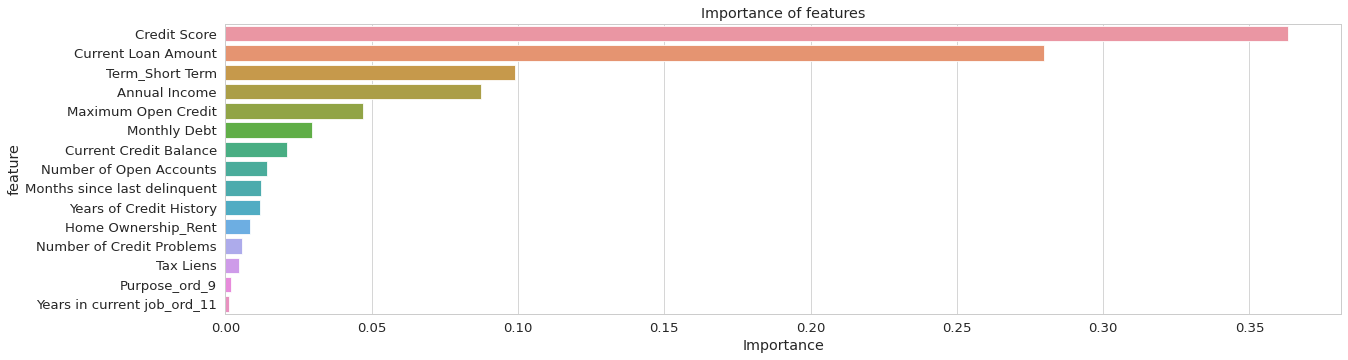

In [555]:
important_features_top = get_feature_imp(X_train.columns, classifier.feature_importances_, get_top=15)

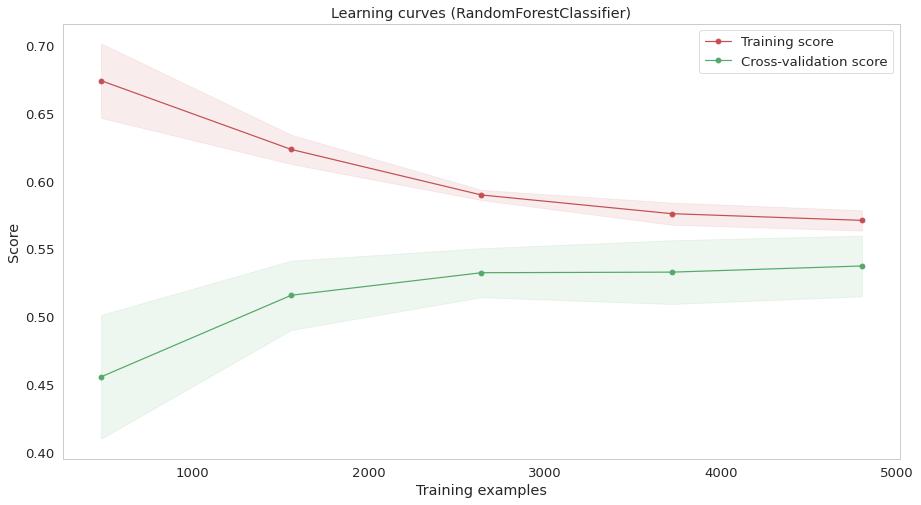

In [556]:
get_learning_curve_plot(classifier, X_train, y_train)

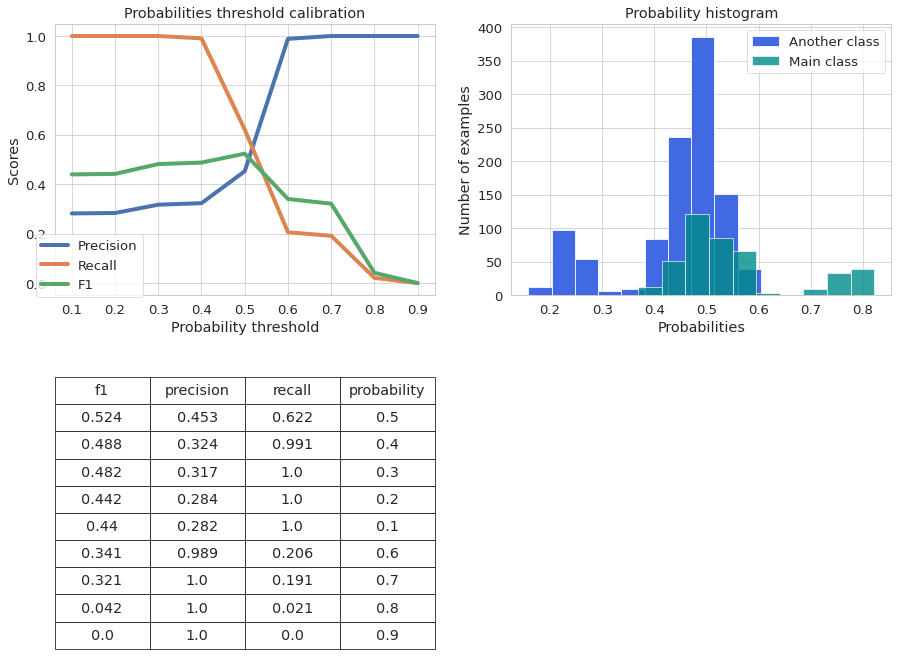

In [557]:
y_val_pred=classifier.predict_proba(X_val)
show_proba_calibration_plots(y_val_pred[:, 1], y_val)